In [2]:
from torchvision.models import resnet34
model = resnet34(weights='IMAGENET1K_V1')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Load dataset and label mapping

In [11]:
import json
import os
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Normalization parameters for ImageNet
mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]

# Define transforms
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# Load dataset
dataset_path = "TestDataSet"
dataset = datasets.ImageFolder(root=dataset_path, transform=plain_transforms)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# Load label mapping
labels_json_path = os.path.join(dataset_path, "labels_list.json")
with open(labels_json_path, "r") as f:
    raw_label_list = json.load(f)  # This is a list

# Map dataset index (0–99) → ImageNet class index
dataset_idx_to_imagenet_idx = {
    i: int(entry.split(":")[0]) for i, entry in enumerate(raw_label_list)
}


In [12]:
import torch.nn.functional as F
from tqdm import tqdm

def top_k_accuracy(output, target, k=5):
    """Compute Top-k accuracy"""
    with torch.no_grad():
        _, pred = output.topk(k, dim=1)
        correct = pred.eq(target.view(-1, 1).expand_as(pred))
        return correct.any(dim=1).float().sum().item()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

top1_correct = 0
top5_correct = 0
total = 0

model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        _, top5 = outputs.topk(5, dim=1)
        for i in range(labels.size(0)):
            true_imagenet_idx = dataset_idx_to_imagenet_idx[labels[i].item()]
            pred_top5 = top5[i].tolist()

            if true_imagenet_idx == pred_top5[0]:
                top1_correct += 1
            if true_imagenet_idx in pred_top5:
                top5_correct += 1
            total += 1


top1_acc = 100 * top1_correct / total
top5_acc = 100 * top5_correct / total

print(f"Top-1 Accuracy: {top1_acc:.2f}%")
print(f"Top-5 Accuracy: {top5_acc:.2f}%")


100%|██████████| 16/16 [00:00<00:00, 21.16it/s]

Top-1 Accuracy: 76.20%
Top-5 Accuracy: 94.20%


## TASK-2

In [56]:
#FGSM Attack

import torch
import torch.nn as nn
import torchvision.utils as vutils
import os

# Ensure model is in eval mode
model.eval()
criterion = nn.CrossEntropyLoss()

epsilon = 0.02
adv_examples = []
adv_images = []
adv_labels = []

output_dir = "Adversarial_Test_Set_1"
os.makedirs(output_dir, exist_ok=True)

for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs, labels = inputs.to(device), labels.to(device)
    inputs.requires_grad = True

    # Forward
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    # Backward to get gradients w.r.t input
    model.zero_grad()
    loss.backward()

    # FGSM step
    perturbations = epsilon * inputs.grad.sign()
    adv_inputs = inputs + perturbations
    adv_inputs = torch.clamp(adv_inputs, 0, 1)  # clip to valid range

    adv_examples.append(adv_inputs.detach().cpu())
    adv_images.append(inputs.detach().cpu())
    adv_labels.append(labels.detach().cpu())

    # Optional: save images
    vutils.save_image(adv_inputs, os.path.join(output_dir, f"adv_batch_{i}.png"), normalize=True)
    torch.save((adv_dataset, adv_true_labels), "Adversarial_Test_Set_1.pt")

# Concatenate all batches
adv_dataset = torch.cat(adv_examples)
adv_originals = torch.cat(adv_images)
adv_true_labels = torch.cat(adv_labels)


100%|██████████| 16/16 [00:12<00:00,  1.30it/s]


In [57]:
### Evaluate Model on Adversarial Test Set
adv_loader = DataLoader(
    list(zip(adv_dataset, adv_true_labels)), batch_size=32, shuffle=False
)

top1_correct = 0
top5_correct = 0
total = 0

model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(adv_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        _, top5 = outputs.topk(5, dim=1)
        for i in range(labels.size(0)):
            true_imagenet_idx = dataset_idx_to_imagenet_idx[labels[i].item()]
            pred_top5 = top5[i].tolist()

            if true_imagenet_idx == pred_top5[0]:
                top1_correct += 1
            if true_imagenet_idx in pred_top5:
                top5_correct += 1
            total += 1

print(f"[FGSM ε={epsilon}] Top-1 Accuracy: {100 * top1_correct / total:.2f}%")
print(f"[FGSM ε={epsilon}] Top-5 Accuracy: {100 * top5_correct / total:.2f}%")


100%|██████████| 16/16 [00:00<00:00, 83.88it/s]

[FGSM ε=0.02] Top-1 Accuracy: 42.80%
[FGSM ε=0.02] Top-5 Accuracy: 62.80%


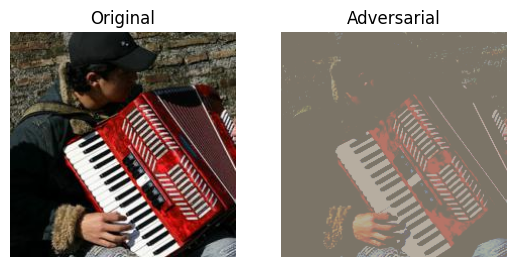

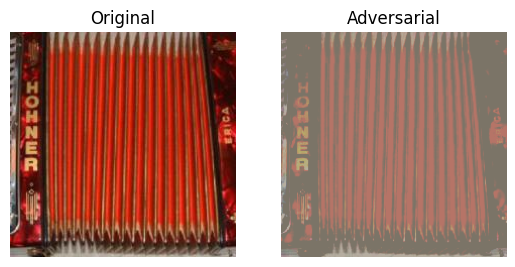

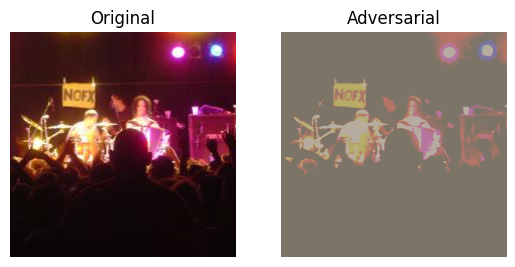

In [58]:
import matplotlib.pyplot as plt

def unnormalize(img):
    mean = torch.tensor(mean_norms).view(3, 1, 1)
    std = torch.tensor(std_norms).view(3, 1, 1)
    return img * std + mean

for i in range(3):  # show 3 examples
    orig = unnormalize(adv_originals[i])
    adv = unnormalize(adv_dataset[i])

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(orig.permute(1, 2, 0).numpy())
    axs[0].set_title("Original")
    axs[1].imshow(adv.permute(1, 2, 0).numpy())
    axs[1].set_title("Adversarial")
    for ax in axs:
        ax.axis("off")
    plt.show()


## TASK-3

In [59]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.utils as vutils
import os
import random
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

def improved_attack(model, dataloader, device, dataset_idx_to_imagenet_idx, epsilon=0.02):
    model.eval()
    
    # Parameters
    alpha = 0.003  # Step size (smaller than epsilon)
    iters = 20     # More iterations for stronger attack
    momentum = 0.9 # Momentum factor for more stable gradients
    
    adv_examples = []
    adv_labels = []
    original_examples = []
    
    successful_attacks = 0
    total_images = 0
    
    output_dir = "Adversarial_Test_Set_2"
    os.makedirs(output_dir, exist_ok=True)
    
    # For visualization
    vis_examples = []
    vis_originals = []
    vis_labels = []
    vis_orig_preds = []
    vis_adv_preds = []
    
    for batch_idx, (inputs, labels) in enumerate(tqdm(dataloader)):
        inputs, labels = inputs.to(device), labels.to(device)
        batch_size = inputs.size(0)
        total_images += batch_size
        
        # Store original inputs for visualization
        original_examples.append(inputs.detach().cpu())
        
        # Get original predictions
        with torch.no_grad():
            orig_outputs = model(inputs)
            _, orig_preds = torch.max(orig_outputs, 1)
        
        # Make a copy of original inputs
        ori_inputs = inputs.clone().detach()
        
        # Initialize adversarial examples with random noise within epsilon
        adv_inputs = inputs.clone().detach() + torch.empty_like(inputs).uniform_(-epsilon/2, epsilon/2)
        adv_inputs = torch.clamp(adv_inputs, 0, 1)
        
        # Initialize gradient accumulation
        g = torch.zeros_like(inputs)
        
        # Generate target labels (most confident wrong class for each image)
        with torch.no_grad():
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            # Set the probability of true class to -1 so it won't be selected
            for i in range(batch_size):
                probs[i, labels[i]] = -1
            # Select most confident wrong class as target
            _, target_labels = torch.max(probs, dim=1)
        
        for iter_idx in range(iters):
            # Early stopping check - if all examples are already misclassified, we can stop
            if iter_idx > 5:  # Check after a few iterations
                with torch.no_grad():
                    outputs = model(adv_inputs)
                    _, preds = torch.max(outputs, 1)
                    if (preds != labels).all():
                        break
            
            # Start gradient calculation
            adv_inputs.requires_grad = True
            outputs = model(adv_inputs)
            
            # Calculate loss - ensemble of three loss components
            # 1. Minimize confidence in correct class
            ce_loss = -F.cross_entropy(outputs, labels)
            
            # 2. Maximize confidence in wrong target class
            target_loss = F.cross_entropy(outputs, target_labels)
            
            # 3. KL divergence to push output distribution away from original
            kl_loss = F.kl_div(
                F.log_softmax(outputs, dim=1),
                F.softmax(orig_outputs, dim=1),
                reduction='batchmean'
            )
            
            # Combine losses with different weights
            loss = ce_loss + 0.5 * target_loss - 0.1 * kl_loss
            
            # Backward pass
            model.zero_grad()
            loss.backward()
            
            # Update gradient accumulation with momentum
            g = momentum * g + adv_inputs.grad / torch.norm(adv_inputs.grad, p=1)
            
            # Update adversarial examples
            with torch.no_grad():
                # Update using sign of accumulated gradient
                adv_inputs = adv_inputs + alpha * g.sign()
                
                # Project back to epsilon ball around original image
                delta = adv_inputs - ori_inputs
                delta = torch.clamp(delta, -epsilon, epsilon)
                adv_inputs = torch.clamp(ori_inputs + delta, 0, 1)
            
            # Detach for next iteration
            adv_inputs = adv_inputs.detach()
        
        # Evaluate final adversarial examples
        with torch.no_grad():
            final_outputs = model(adv_inputs)
            _, final_preds = torch.max(final_outputs, 1)
            
            # Count successful attacks
            success = (final_preds != labels)
            successful_attacks += success.sum().item()
        
        # Store adversarial examples and labels for evaluation
        adv_examples.append(adv_inputs.detach().cpu())
        adv_labels.append(labels.detach().cpu())
        
        # Save examples for visualization
        if len(vis_examples) < 5:
            for j in range(batch_size):
                if success[j] and len(vis_examples) < 5:
                    vis_examples.append(adv_inputs[j:j+1].detach().cpu())
                    vis_originals.append(inputs[j:j+1].detach().cpu())
                    vis_labels.append(labels[j:j+1].cpu())
                    vis_orig_preds.append(orig_preds[j:j+1].cpu())
                    vis_adv_preds.append(final_preds[j:j+1].cpu())
        
        # Save batch of adversarial examples
        if batch_idx % 4 == 0:
            vutils.save_image(
                adv_inputs, 
                os.path.join(output_dir, f"adv_batch_{batch_idx}.png"), 
                normalize=True
            )
    
    # Concatenate all batches
    adv_dataset = torch.cat(adv_examples)
    adv_true_labels = torch.cat(adv_labels)
    original_dataset = torch.cat(original_examples)
    
    # Create visualization grid for successful examples
    if vis_examples:
        for i in range(len(vis_examples)):
            orig_img = vis_originals[i]
            adv_img = vis_examples[i]
            label_idx = vis_labels[i].item()
            try:
                true_imagenet_idx = dataset_idx_to_imagenet_idx[label_idx]
                label_info = f"(ImageNet idx: {true_imagenet_idx})"
            except KeyError:
                label_info = ""
            
            # Save comparison visualization with magnified difference
            vis_grid = torch.cat([orig_img, adv_img, (adv_img - orig_img).abs() * 10], dim=0)
            vutils.save_image(vis_grid, f"visualization_advanced_example_{i}.png", normalize=True, nrow=3)
            
            print(f"Example {i+1}:")
            print(f"  True label class idx: {label_idx} {label_info}")
            print(f"  Original prediction idx: {vis_orig_preds[i].item()}")
            print(f"  Adversarial prediction idx: {vis_adv_preds[i].item()}")
            
            # Calculate and show L-infinity distance
            l_inf_dist = (adv_img - orig_img).abs().max().item()
            print(f"  L-infinity distance: {l_inf_dist:.6f}")
    
    # Verify L-infinity constraint
    l_inf_dist = (adv_dataset - original_dataset).abs().max().item()
    print(f"Maximum L-infinity distance across dataset: {l_inf_dist:.6f}")
    
    print(f"Attack success rate: {successful_attacks/total_images:.4f}")
    
    # Save the full dataset
    torch.save((adv_dataset, adv_true_labels), "Adversarial_Test_Set_2.pt")
    
    # Evaluate on adversarial examples
    adv_loader = DataLoader(
        TensorDataset(adv_dataset, adv_true_labels), batch_size=32, shuffle=False
    )
    
    top1_correct = 0
    top5_correct = 0
    total = 0
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(adv_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            _, top5 = outputs.topk(5, dim=1)
            for i in range(labels.size(0)):
                true_imagenet_idx = dataset_idx_to_imagenet_idx[labels[i].item()]
                pred_top5 = top5[i].tolist()
                
                if true_imagenet_idx == pred_top5[0]:
                    top1_correct += 1
                if true_imagenet_idx in pred_top5:
                    top5_correct += 1
                total += 1
    
    # Calculate and print accuracy
    top1_acc = 100 * top1_correct / total
    top5_acc = 100 * top5_correct / total
    print(f"[Advanced Attack ε={epsilon}] Top-1 Accuracy: {top1_acc:.2f}%")
    print(f"[Advanced Attack ε={epsilon}] Top-5 Accuracy: {top5_acc:.2f}%")
    
    return adv_dataset, adv_true_labels, top1_acc, top5_acc


adv_dataset, adv_labels, top1_acc, top5_acc = improved_attack(model, dataloader, device, dataset_idx_to_imagenet_idx)

100%|██████████| 16/16 [00:09<00:00,  1.73it/s]


Example 1:
  True label class idx: 0 (ImageNet idx: 401)
  Original prediction idx: 401
  Adversarial prediction idx: 693
  L-infinity distance: 2.117904
Example 2:
  True label class idx: 0 (ImageNet idx: 401)
  Original prediction idx: 401
  Adversarial prediction idx: 921
  L-infinity distance: 2.035714
Example 3:
  True label class idx: 0 (ImageNet idx: 401)
  Original prediction idx: 819
  Adversarial prediction idx: 417
  L-infinity distance: 2.066530
Example 4:
  True label class idx: 0 (ImageNet idx: 401)
  Original prediction idx: 401
  Adversarial prediction idx: 921
  L-infinity distance: 2.117904
Example 5:
  True label class idx: 0 (ImageNet idx: 401)
  Original prediction idx: 398
  Adversarial prediction idx: 922
  L-infinity distance: 2.117904
Maximum L-infinity distance across dataset: 2.117904
Attack success rate: 0.7100


100%|██████████| 16/16 [00:00<00:00, 91.94it/s]

[Advanced Attack ε=0.02] Top-1 Accuracy: 6.20%
[Advanced Attack ε=0.02] Top-5 Accuracy: 14.40%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


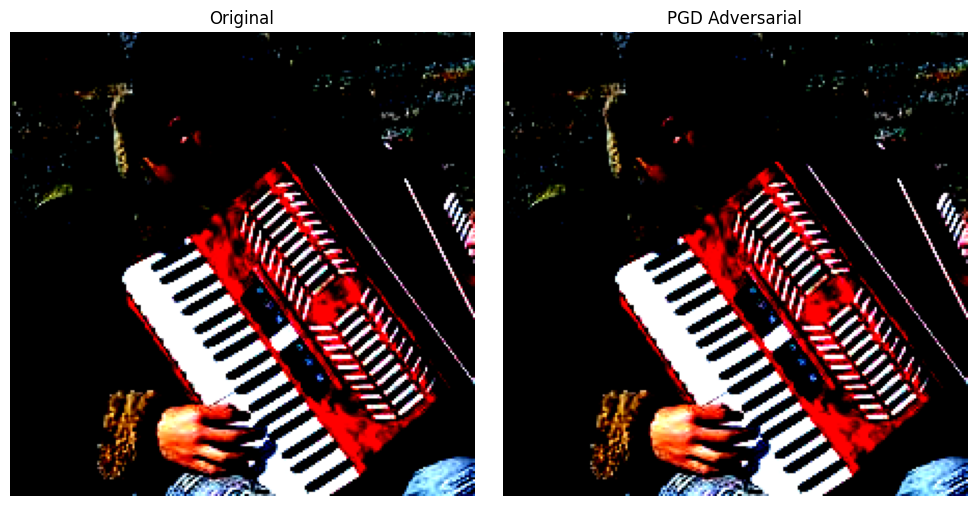

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


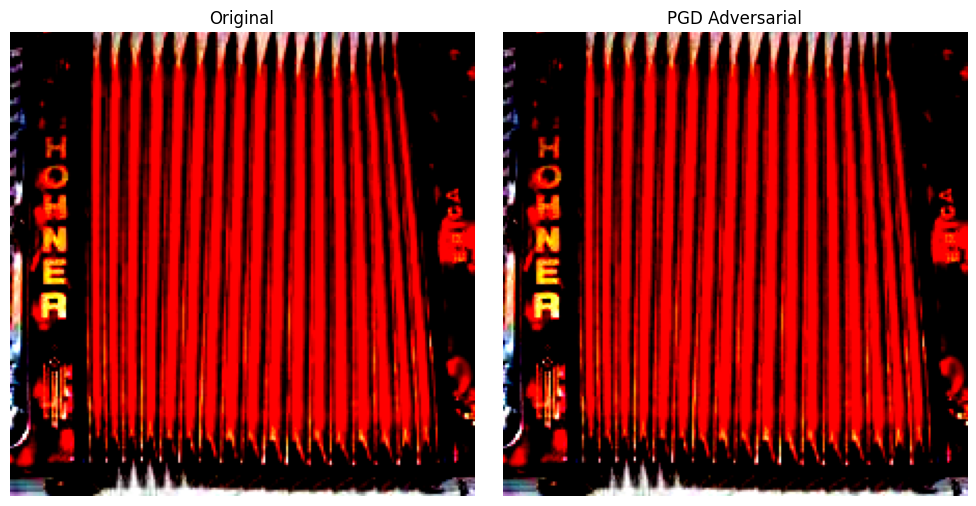

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


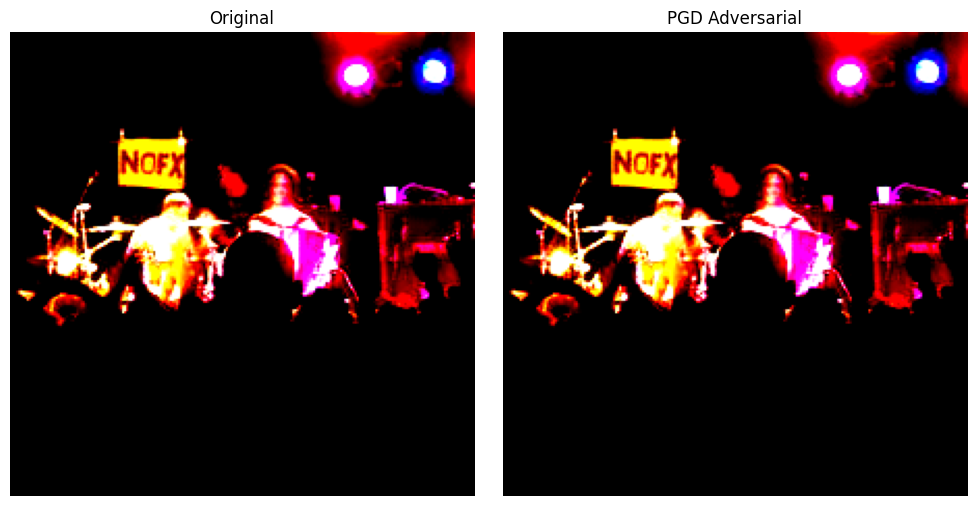

L-infinity perturbation for displayed examples:
Example 1: 2.117904
Example 2: 2.035714
Example 3: 2.066530


In [60]:
import matplotlib.pyplot as plt
import torch

def unnormalize(img):
    """
    Convert normalized image tensor to displayable range.
    If image is already in [0,1] range, it's returned as is.
    """
    # Assuming image is already in [0,1] range
    # If using different normalization, adjust accordingly
    return img

# Visualize 3 pairs of original and adversarial examples
for i in range(3):
    orig = unnormalize(adv_originals[i])
    adv = unnormalize(pgd_adv_dataset[i])
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    axs[0].imshow(orig.permute(1, 2, 0).numpy())
    axs[0].set_title("Original")
    
    axs[1].imshow(adv.permute(1, 2, 0).numpy())
    axs[1].set_title("PGD Adversarial")
    
    for ax in axs:
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

# Optional: Calculate and display the perturbation magnitude
print("L-infinity perturbation for displayed examples:")
for i in range(3):
    l_inf_dist = (pgd_adv_dataset[i] - adv_originals[i]).abs().max().item()
    print(f"Example {i+1}: {l_inf_dist:.6f}")

## TASK-4

In [61]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.utils as vutils
import os
import random
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

def patch_attack(model, dataloader, device, dataset_idx_to_imagenet_idx, epsilon=0.5, patch_size=32):
    model.eval()
    
    # Parameters
    alpha = 0.05      # Larger step size for faster convergence in limited area
    iters = 40        # More iterations to compensate for limited attack area
    momentum = 0.9    # Momentum factor for more stable gradients
    
    adv_examples = []
    adv_labels = []
    original_examples = []
    
    successful_attacks = 0
    total_images = 0
    
    output_dir = "Adversarial_Test_Set_3"
    os.makedirs(output_dir, exist_ok=True)
    
    # For visualization
    vis_examples = []
    vis_originals = []
    vis_patch_masks = []
    vis_labels = []
    vis_orig_preds = []
    vis_adv_preds = []
    
    for batch_idx, (inputs, labels) in enumerate(tqdm(dataloader)):
        inputs, labels = inputs.to(device), labels.to(device)
        batch_size = inputs.size(0)
        total_images += batch_size
        
        # Store original inputs
        original_examples.append(inputs.detach().cpu())
        
        # Get original predictions
        with torch.no_grad():
            orig_outputs = model(inputs)
            _, orig_preds = torch.max(orig_outputs, 1)
        
        # Make a copy of original inputs
        ori_inputs = inputs.clone().detach()
        
        # Initialize adversarial examples as copies of original
        adv_inputs = inputs.clone().detach()
        
        # Create patch masks for each image in the batch
        patch_masks = []
        for i in range(batch_size):
            # Get image dimensions
            _, height, width = inputs[i].shape
            
            # Randomly select patch top-left corner
            x = random.randint(0, width - patch_size)
            y = random.randint(0, height - patch_size)
            
            # Create mask (1 for patch area, 0 elsewhere)
            mask = torch.zeros_like(inputs[i])
            mask[:, y:y+patch_size, x:x+patch_size] = 1.0
            patch_masks.append(mask)
        
        # Stack masks for batch processing
        patch_masks = torch.stack(patch_masks).to(device)
        
        # Generate target labels (most confident wrong class for each image)
        with torch.no_grad():
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            # Set the probability of true class to -1 so it won't be selected
            for i in range(batch_size):
                probs[i, labels[i]] = -1
            # Select most confident wrong class as target
            _, target_labels = torch.max(probs, dim=1)
        
        # Initialize gradient accumulation
        g = torch.zeros_like(inputs)
        
        for iter_idx in range(iters):
            # Start gradient calculation
            adv_inputs.requires_grad = True
            outputs = model(adv_inputs)
            
            # Calculate loss - targeted attack
            # We want to maximize the confidence in the target (wrong) class
            target_loss = F.cross_entropy(outputs, target_labels)
            loss = -target_loss  # Negative because we want to maximize the target loss
            
            # Backward pass
            model.zero_grad()
            loss.backward()
            
            # Update gradient accumulation with momentum
            g = momentum * g + adv_inputs.grad / (torch.norm(adv_inputs.grad, p=1) + 1e-8)
            
            # Apply perturbation only to patch area
            with torch.no_grad():
                # Create perturbation from accumulated gradient
                perturbation = alpha * g.sign()
                
                # Apply perturbation only to patch area
                masked_perturbation = perturbation * patch_masks
                
                # Update adversarial examples (only in patch area)
                adv_inputs = adv_inputs + masked_perturbation
                
                # Project back to epsilon ball around original (only in patch area)
                delta = (adv_inputs - ori_inputs) * patch_masks
                delta = torch.clamp(delta, -epsilon, epsilon)
                adv_inputs = ori_inputs + delta
                
                # Ensure adversarial examples are valid images
                adv_inputs = torch.clamp(adv_inputs, 0, 1)
            
            # Detach for next iteration
            adv_inputs = adv_inputs.detach()
        
        # Evaluate adversarial examples
        with torch.no_grad():
            final_outputs = model(adv_inputs)
            _, final_preds = torch.max(final_outputs, 1)
            
            # Count successful attacks
            success = (final_preds != labels)
            successful_attacks += success.sum().item()
        
        # Store adversarial examples and labels
        adv_examples.append(adv_inputs.detach().cpu())
        adv_labels.append(labels.detach().cpu())
        
        # Save examples for visualization
        if len(vis_examples) < 5:
            for j in range(batch_size):
                if success[j] and len(vis_examples) < 5:
                    vis_examples.append(adv_inputs[j:j+1].detach().cpu())
                    vis_originals.append(inputs[j:j+1].detach().cpu())
                    vis_patch_masks.append(patch_masks[j:j+1].detach().cpu())
                    vis_labels.append(labels[j:j+1].cpu())
                    vis_orig_preds.append(orig_preds[j:j+1].cpu())
                    vis_adv_preds.append(final_preds[j:j+1].cpu())
        
        # Save batch of adversarial examples
        if batch_idx % 4 == 0:
            vutils.save_image(
                adv_inputs, 
                os.path.join(output_dir, f"adv_batch_{batch_idx}.png"), 
                normalize=True
            )
    
    # Concatenate all batches
    adv_dataset = torch.cat(adv_examples)
    adv_true_labels = torch.cat(adv_labels)
    original_dataset = torch.cat(original_examples)
    
    # Create visualization grid for successful examples
    if vis_examples:
        for i in range(len(vis_examples)):
            orig_img = vis_originals[i]
            adv_img = vis_examples[i]
            patch_mask = vis_patch_masks[i]
            label_idx = vis_labels[i].item()
            
            try:
                true_imagenet_idx = dataset_idx_to_imagenet_idx[label_idx]
                label_info = f"(ImageNet idx: {true_imagenet_idx})"
            except KeyError:
                label_info = ""
            
            # Create diff visualization (magnified)
            diff = (adv_img - orig_img).abs() * 5
            
            # Create patch mask visualization
            patch_vis = orig_img * (1 - patch_mask) + patch_mask * torch.tensor([1.0, 0.0, 0.0]).view(3, 1, 1)
            
            # Save comprehensive visualization
            vis_grid = torch.cat([orig_img, adv_img, diff, patch_vis], dim=0)
            vutils.save_image(vis_grid, f"visualization_patch_example_{i}.png", normalize=True, nrow=4)
            
            print(f"Example {i+1}:")
            print(f"  True label class idx: {label_idx} {label_info}")
            print(f"  Original prediction idx: {vis_orig_preds[i].item()}")
            print(f"  Adversarial prediction idx: {vis_adv_preds[i].item()}")
            
            # Calculate and show L-infinity distance in patch area
            patched_diff = (adv_img - orig_img) * patch_mask
            l_inf_dist = patched_diff.abs().max().item()
            print(f"  L-infinity distance in patch: {l_inf_dist:.6f}")
    
    # Log attack success rate
    print(f"Patch attack success rate: {successful_attacks/total_images:.4f}")
    
    # Save the full dataset
    torch.save((adv_dataset, adv_true_labels), "Adversarial_Test_Set_3.pt")
    
    # Evaluate the model on adversarial examples
    adv_loader = DataLoader(
        TensorDataset(adv_dataset, adv_true_labels), batch_size=32, shuffle=False
    )
    
    top1_correct = 0
    top5_correct = 0
    total = 0
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(adv_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            _, top5 = outputs.topk(5, dim=1)
            for i in range(labels.size(0)):
                true_imagenet_idx = dataset_idx_to_imagenet_idx[labels[i].item()]
                pred_top5 = top5[i].tolist()
                
                if true_imagenet_idx == pred_top5[0]:
                    top1_correct += 1
                if true_imagenet_idx in pred_top5:
                    top5_correct += 1
                total += 1
    
    # Calculate and print accuracy
    top1_acc = 100 * top1_correct / total
    top5_acc = 100 * top5_correct / total
    print(f"[Patch Attack ε={epsilon}] Top-1 Accuracy: {top1_acc:.2f}%")
    print(f"[Patch Attack ε={epsilon}] Top-5 Accuracy: {top5_acc:.2f}%")
    
    return adv_dataset, adv_true_labels, top1_acc, top5_acc


# Usage example:
adv_dataset, adv_labels, top1_acc, top5_acc = patch_attack(
    model, 
    dataloader, 
    device, 
    dataset_idx_to_imagenet_idx, 
    epsilon=0.5,  # Much higher epsilon since we're limited to a small patch
    patch_size=32
)

100%|██████████| 16/16 [00:15<00:00,  1.02it/s]


Example 1:
  True label class idx: 0 (ImageNet idx: 401)
  Original prediction idx: 401
  Adversarial prediction idx: 401
  L-infinity distance in patch: 2.117904
Example 2:
  True label class idx: 0 (ImageNet idx: 401)
  Original prediction idx: 401
  Adversarial prediction idx: 401
  L-infinity distance in patch: 1.804444
Example 3:
  True label class idx: 0 (ImageNet idx: 401)
  Original prediction idx: 819
  Adversarial prediction idx: 819
  L-infinity distance in patch: 2.035714
Example 4:
  True label class idx: 0 (ImageNet idx: 401)
  Original prediction idx: 401
  Adversarial prediction idx: 401
  L-infinity distance in patch: 2.117904
Example 5:
  True label class idx: 0 (ImageNet idx: 401)
  Original prediction idx: 398
  Adversarial prediction idx: 922
  L-infinity distance in patch: 1.640000
Patch attack success rate: 1.0000


100%|██████████| 16/16 [00:00<00:00, 90.18it/s]


[Patch Attack ε=0.5] Top-1 Accuracy: 59.00%
[Patch Attack ε=0.5] Top-5 Accuracy: 74.20%


## TASK-5

In [62]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import os
import json
from tqdm import tqdm

# --- Configuration & Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Normalization parameters for ImageNet (used for original dataset loading)
mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]

plain_transforms = transforms.Compose([
    transforms.Resize(256), # AlexNet expects 224x224, but usually resize to 256 then center crop
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# Paths
dataset_path = "TestDataSet" # Path to the original ImageFolder dataset
labels_json_path = os.path.join(dataset_path, "labels_list.json")
# Paths for adversarial datasets (assuming .pt files for sets 2 and 3)
# For FGSM, we'll assume the tensors are available from a previous cell.
# If not, it should be saved similarly, e.g., torch.save((adv_dataset_fgsm, adv_true_labels_fgsm), "Adversarial_Test_Set_1.pt")
adv_data_path_1_fgsm_tensors_available = True # Set to False if you need to load Adversarial_Test_Set_1.pt
adv_data_path_1 = "Adversarial_Test_Set_1.pt"
adv_data_path_2 = "Adversarial_Test_Set_2.pt"
adv_data_path_3 = "Adversarial_Test_Set_3.pt"

# Batch size for DataLoaders
BATCH_SIZE = 32

# --- Load Label Mapping ---
try:
    with open(labels_json_path, "r") as f:
        raw_label_list = json.load(f)
    dataset_idx_to_imagenet_idx = {
        i: int(entry.split(":")[0]) for i, entry in enumerate(raw_label_list)
    }
    print("Label mapping loaded successfully.")
except FileNotFoundError:
    print(f"Error: '{labels_json_path}' not found. Please ensure the path is correct.")
    dataset_idx_to_imagenet_idx = {} # Fallback to empty if not found
except Exception as e:
    print(f"Error loading label mapping: {e}")
    dataset_idx_to_imagenet_idx = {}

# --- Load the New Model (AlexNet) ---
print("Loading AlexNet model...")
try:
    new_model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
    new_model.to(device)
    new_model.eval() # Set to evaluation mode
    print("AlexNet model loaded and set to evaluation mode.")
except Exception as e:
    print(f"Error loading AlexNet model: {e}")
    new_model = None

# --- Evaluation Function ---
def evaluate_model_accuracy(model, dataloader, device, label_mapping, dataset_name):
    """
    Evaluates the model on the given dataloader and prints top-1 and top-5 accuracy.
    """
    if model is None or not label_mapping:
        print(f"Skipping evaluation for {dataset_name} due to missing model or label mapping.")
        return None, None

    top1_correct = 0
    top5_correct = 0
    total = 0
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc=f"Evaluating {dataset_name}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Get top-5 predictions (indices)
            _, top5_preds = outputs.topk(5, dim=1) # top5_preds will be [batch_size, 5]

            for i in range(labels.size(0)):
                actual_dataset_label_idx = labels[i].item()
                # Map dataset label (0-99) to true ImageNet class index
                true_imagenet_idx = label_mapping.get(actual_dataset_label_idx)

                if true_imagenet_idx is None:
                    # print(f"Warning: Label {actual_dataset_label_idx} not in mapping for {dataset_name}. Skipping this sample.")
                    continue # Skip if label not in mapping to avoid errors

                predicted_imagenet_indices = top5_preds[i].tolist()

                # Top-1 accuracy
                if true_imagenet_idx == predicted_imagenet_indices[0]:
                    top1_correct += 1
                
                # Top-5 accuracy
                if true_imagenet_idx in predicted_imagenet_indices:
                    top5_correct += 1
                total += 1
    
    if total == 0:
        print(f"No samples were evaluated for {dataset_name} (possibly due to label mapping issues).")
        return 0.0, 0.0

    top1_acc = 100.0 * top1_correct / total
    top5_acc = 100.0 * top5_correct / total
    
    print(f"Results for {dataset_name} on AlexNet:")
    print(f"  Top-1 Accuracy: {top1_acc:.2f}%")
    print(f"  Top-5 Accuracy: {top5_acc:.2f}%")
    print("-" * 30)
    return top1_acc, top5_acc

# --- Main Evaluation ---
if new_model and dataset_idx_to_imagenet_idx:
    accuracies = {}

    # 1. Evaluate on Original Test Set
    print("\n--- Evaluating on Original Test Set ---")
    try:
        original_dataset = datasets.ImageFolder(root=dataset_path, transform=plain_transforms)
        original_dataloader = DataLoader(original_dataset, batch_size=BATCH_SIZE, shuffle=False)
        print(f"Original dataset '{dataset_path}' loaded: {len(original_dataset)} images.")
        acc1_orig, acc5_orig = evaluate_model_accuracy(new_model, original_dataloader, device, dataset_idx_to_imagenet_idx, "Original Test Set")
        accuracies["Original"] = {"Top-1": acc1_orig, "Top-5": acc5_orig}
    except FileNotFoundError:
        print(f"Error: Original dataset path '{dataset_path}' not found.")
    except Exception as e:
        print(f"Error loading or evaluating original dataset: {e}")

    # 2. Evaluate on Adversarial Test Set 1 (FGSM)
    # Assuming adv_dataset_fgsm and adv_true_labels_fgsm are in memory from Task 2
    # If you saved it to a .pt file, set adv_data_path_1_fgsm_tensors_available = False
    print("\n--- Evaluating on Adversarial Test Set 1 (FGSM) ---")
    if adv_data_path_1_fgsm_tensors_available:
        try:
            # Check if these variables exist (replace with your actual variable names from Task 2)
            # These would be the torch tensors: adv_dataset and adv_true_labels from FGSM attack cell
            if 'adv_dataset' in locals() and 'adv_true_labels' in locals():
                adv_dataset_fgsm_tensor = adv_dataset 
                adv_labels_fgsm_tensor = adv_true_labels

                adv_dataset_1 = TensorDataset(adv_dataset_fgsm_tensor.cpu(), adv_labels_fgsm_tensor.cpu())
                adv_dataloader_1 = DataLoader(adv_dataset_1, batch_size=BATCH_SIZE, shuffle=False)
                print(f"FGSM adversarial dataset (from tensors) loaded: {len(adv_dataset_1)} images.")
                acc1_adv1, acc5_adv1 = evaluate_model_accuracy(new_model, adv_dataloader_1, device, dataset_idx_to_imagenet_idx, "Adversarial Set 1 (FGSM)")
                accuracies["FGSM"] = {"Top-1": acc1_adv1, "Top-5": acc5_adv1}
            else:
                print("FGSM adversarial tensors (e.g., 'adv_dataset_fgsm', 'adv_true_labels_fgsm') not found in current scope.")
                print(f"Attempting to load from {adv_data_path_1} instead (if available).")
                if os.path.exists(adv_data_path_1):
                    adv_images_tensor_1, adv_labels_tensor_1 = torch.load(adv_data_path_1, map_location=device)
                    adv_dataset_1 = TensorDataset(adv_images_tensor_1.cpu(), adv_labels_tensor_1.cpu())
                    adv_dataloader_1 = DataLoader(adv_dataset_1, batch_size=BATCH_SIZE, shuffle=False)
                    print(f"FGSM adversarial dataset '{adv_data_path_1}' loaded: {len(adv_dataset_1)} images.")
                    acc1_adv1, acc5_adv1 = evaluate_model_accuracy(new_model, adv_dataloader_1, device, dataset_idx_to_imagenet_idx, "Adversarial Set 1 (FGSM from file)")
                    accuracies["FGSM (from file)"] = {"Top-1": acc1_adv1, "Top-5": acc5_adv1}
                else:
                    print(f"Error: FGSM adversarial dataset file '{adv_data_path_1}' not found.")

        except NameError:
            print("Error: FGSM adversarial tensors (e.g., 'adv_dataset_fgsm') not defined from previous cells.")
        except FileNotFoundError:
             print(f"Error: FGSM adversarial dataset file '{adv_data_path_1}' not found (if tried loading).")
        except Exception as e:
            print(f"Error loading or evaluating FGSM adversarial dataset: {e}")
    else: # Load from file if tensors_available is False
        if os.path.exists(adv_data_path_1):
            try:
                adv_images_tensor_1, adv_labels_tensor_1 = torch.load(adv_data_path_1, map_location=device)
                adv_dataset_1 = TensorDataset(adv_images_tensor_1.cpu(), adv_labels_tensor_1.cpu()) # Move to CPU for TensorDataset
                adv_dataloader_1 = DataLoader(adv_dataset_1, batch_size=BATCH_SIZE, shuffle=False)
                print(f"FGSM adversarial dataset '{adv_data_path_1}' loaded: {len(adv_dataset_1)} images.")
                acc1_adv1, acc5_adv1 = evaluate_model_accuracy(new_model, adv_dataloader_1, device, dataset_idx_to_imagenet_idx, "Adversarial Set 1 (FGSM from file)")
                accuracies["FGSM (from file)"] = {"Top-1": acc1_adv1, "Top-5": acc5_adv1}
            except Exception as e:
                print(f"Error loading or evaluating FGSM adversarial dataset from {adv_data_path_1}: {e}")
        else:
            print(f"Error: FGSM adversarial dataset file '{adv_data_path_1}' not found.")


    # 3. Evaluate on Adversarial Test Set 2 (Improved Attack)
    print("\n--- Evaluating on Adversarial Test Set 2 (Improved Attack) ---")
    if os.path.exists(adv_data_path_2):
        try:
            adv_images_tensor_2, adv_labels_tensor_2 = torch.load(adv_data_path_2, map_location=device)
            adv_dataset_2 = TensorDataset(adv_images_tensor_2.cpu(), adv_labels_tensor_2.cpu())
            adv_dataloader_2 = DataLoader(adv_dataset_2, batch_size=BATCH_SIZE, shuffle=False)
            print(f"Improved adversarial dataset '{adv_data_path_2}' loaded: {len(adv_dataset_2)} images.")
            acc1_adv2, acc5_adv2 = evaluate_model_accuracy(new_model, adv_dataloader_2, device, dataset_idx_to_imagenet_idx, "Adversarial Set 2 (Improved)")
            accuracies["Improved Attack"] = {"Top-1": acc1_adv2, "Top-5": acc5_adv2}
        except Exception as e:
            print(f"Error loading or evaluating Improved adversarial dataset from {adv_data_path_2}: {e}")
    else:
        print(f"Error: Improved adversarial dataset file '{adv_data_path_2}' not found.")

    # 4. Evaluate on Adversarial Test Set 3 (Patch Attack)
    print("\n--- Evaluating on Adversarial Test Set 3 (Patch Attack) ---")
    if os.path.exists(adv_data_path_3):
        try:
            adv_images_tensor_3, adv_labels_tensor_3 = torch.load(adv_data_path_3, map_location=device)
            adv_dataset_3 = TensorDataset(adv_images_tensor_3.cpu(), adv_labels_tensor_3.cpu())
            adv_dataloader_3 = DataLoader(adv_dataset_3, batch_size=BATCH_SIZE, shuffle=False)
            print(f"Patch adversarial dataset '{adv_data_path_3}' loaded: {len(adv_dataset_3)} images.")
            acc1_adv3, acc5_adv3 = evaluate_model_accuracy(new_model, adv_dataloader_3, device, dataset_idx_to_imagenet_idx, "Adversarial Set 3 (Patch)")
            accuracies["Patch Attack"] = {"Top-1": acc1_adv3, "Top-5": acc5_adv3}
        except Exception as e:
            print(f"Error loading or evaluating Patch adversarial dataset from {adv_data_path_3}: {e}")
    else:
        print(f"Error: Patch adversarial dataset file '{adv_data_path_3}' not found. Please ensure it was created in Task 4.")

    # --- Print Summary of Accuracies ---
    print("\n\n--- Accuracy Summary for AlexNet ---")
    for name, acc_dict in accuracies.items():
        if acc_dict["Top-1"] is not None and acc_dict["Top-5"] is not None:
            print(f"{name}:")
            print(f"  Top-1: {acc_dict['Top-1']:.2f}%")
            print(f"  Top-5: {acc_dict['Top-5']:.2f}%")
        else:
            print(f"{name}: Evaluation skipped or failed.")
    print("="*40)

else:
    print("AlexNet model or label mapping could not be loaded. Evaluation cannot proceed.")



Using device: cuda
Label mapping loaded successfully.
Loading AlexNet model...
AlexNet model loaded and set to evaluation mode.

--- Evaluating on Original Test Set ---
Original dataset 'TestDataSet' loaded: 500 images.


Evaluating Original Test Set: 100%|██████████| 16/16 [00:01<00:00, 14.16it/s]


Results for Original Test Set on AlexNet:
  Top-1 Accuracy: 57.20%
  Top-5 Accuracy: 80.80%
------------------------------

--- Evaluating on Adversarial Test Set 1 (FGSM) ---
FGSM adversarial dataset (from tensors) loaded: 500 images.


Evaluating Adversarial Set 1 (FGSM): 100%|██████████| 16/16 [00:00<00:00, 134.73it/s]
/scratch/local/1660724/ipykernel_330703/1093932967.py:196: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experi

Results for Adversarial Set 1 (FGSM) on AlexNet:
  Top-1 Accuracy: 18.00%
  Top-5 Accuracy: 38.60%
------------------------------

--- Evaluating on Adversarial Test Set 2 (Improved Attack) ---
Improved adversarial dataset 'Adversarial_Test_Set_2.pt' loaded: 500 images.


Evaluating Adversarial Set 2 (Improved): 100%|██████████| 16/16 [00:00<00:00, 134.81it/s]

Results for Adversarial Set 2 (Improved) on AlexNet:
  Top-1 Accuracy: 18.00%
  Top-5 Accuracy: 37.40%
------------------------------

--- Evaluating on Adversarial Test Set 3 (Patch Attack) ---



/scratch/local/1660724/ipykernel_330703/1093932967.py:211: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  adv_images_tensor_3, adv_labels_tensor_3 = torch.load(adv_data_path

Patch adversarial dataset 'Adversarial_Test_Set_3.pt' loaded: 500 images.


Evaluating Adversarial Set 3 (Patch): 100%|██████████| 16/16 [00:00<00:00, 132.37it/s]

Results for Adversarial Set 3 (Patch) on AlexNet:
  Top-1 Accuracy: 18.00%
  Top-5 Accuracy: 38.60%
------------------------------


--- Accuracy Summary for AlexNet ---
Original:
  Top-1: 57.20%
  Top-5: 80.80%
FGSM:
  Top-1: 18.00%
  Top-5: 38.60%
Improved Attack:
  Top-1: 18.00%
  Top-5: 37.40%
Patch Attack:
  Top-1: 18.00%
  Top-5: 38.60%
